# Лабораторная работа №5.
## Свёрточные нейронные сети (PyTorch)

**Задание:** ознакомьтесь с практической работой №14. На основе неё постройте нейронную сеть, настроенную на определение объектов из датасета [CIFAR-10](https://paperswithcode.com/dataset/cifar-10).

В качестве ориентира можно использовать официальный туториал PyTorch по CIFAR-10: [CIFAR10 Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [2]:
# Импорт необходимых библиотек
import os
import random

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

# Для воспроизводимости
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print(f"PyTorch version: {torch.__version__}")
print(f"TorchVision version: {torchvision.__version__}")

print("\n" + "=" * 60)
print("НАСТРОЙКА GPU (PyTorch)")
print("=" * 60)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Устройство: {device}")

if device.type == "cuda":
    print(f"CUDA runtime (torch): {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    major, minor = torch.cuda.get_device_capability(0)
    print(f"Compute capability: {major}.{minor}")

    # Оптимизации для CNN
    torch.backends.cudnn.benchmark = True
    print("✓ cuDNN benchmark включён")

    # Mixed precision
    use_amp = True
    print("✓ AMP (autocast + GradScaler) будет использован")
else:
    use_amp = False
    print("⚠ GPU не найдены — обучение будет выполняться на CPU")

# Быстрая sanity-проверка GPU
x = torch.randn(1024, 1024, device=device)
y = x @ x.t()
print(f"Sanity-check matmul: {y.mean().item():.6f}")
print("=" * 60 + "\n")

PyTorch version: 2.9.1+cu128
TorchVision version: 0.24.1+cu128

НАСТРОЙКА GPU (PyTorch)
Устройство: cuda
CUDA runtime (torch): 12.8
GPU: NVIDIA GeForce RTX 5060 Ti
Compute capability: 12.0
✓ cuDNN benchmark включён
✓ AMP (autocast + GradScaler) будет использован
Sanity-check matmul: 0.998483



## Загрузка и предобработка данных CIFAR-10


In [3]:
# Загрузка данных CIFAR-10 (torchvision)
# Для визуализации используем только ToTensor(), чтобы изображения были в [0, 1]
raw_transform = transforms.ToTensor()

# Для обучения добавим нормализацию (стандартная для CIFAR-10)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
])

raw_train = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=raw_transform)
raw_test = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=raw_transform)

train_dataset = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=test_transform)

# Классы CIFAR-10
class_names = ['самолет', 'автомобиль', 'птица', 'кот', 'олень',
               'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

print(f"Размер train: {len(train_dataset)}")
print(f"Размер test: {len(test_dataset)}")

img0, label0 = raw_train[0]
print(f"Пример изображения: shape={tuple(img0.shape)}, dtype={img0.dtype}, min={img0.min().item():.3f}, max={img0.max().item():.3f}")
print(f"Пример метки: {label0} ({class_names[label0]})")


/home/ds/anaconda3/envs/volsu-mmad/lib/python3.11/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Размер train: 50000
Размер test: 10000
Пример изображения: shape=(3, 32, 32), dtype=torch.float32, min=0.000, max=1.000
Пример метки: 6 (лягушка)


In [4]:
# В PyTorch нам не нужен one-hot encoding: используем целочисленные метки 0..9.
# Нормализация/аугментации уже заданы в transform'ах выше.

# DataLoader'ы
batch_size = 256 if device.type == "cuda" else 128
print(f"Используется batch_size: {batch_size}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=(device.type == "cuda"))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=(device.type == "cuda"))

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")


Используется batch_size: 256
Train batches: 196
Test batches: 40


## Визуализация примеров данных


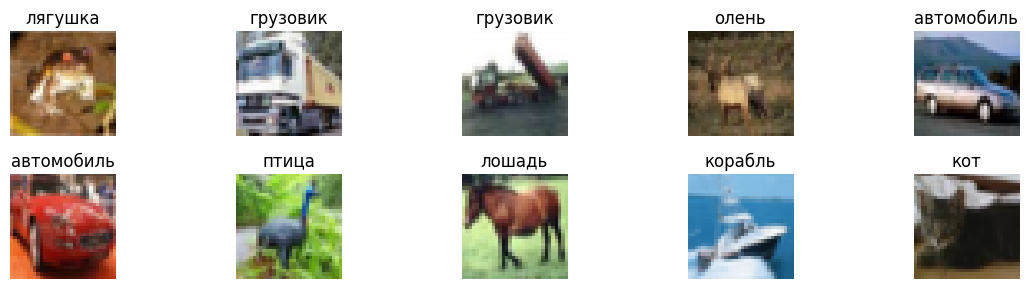

In [5]:
# Визуализация нескольких изображений
plt.figure(figsize=(12, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    img, label = raw_train[i]  # img: (C,H,W) в [0, 1]
    plt.imshow(img.permute(1, 2, 0))
    plt.title(class_names[label])
    plt.axis('off')
plt.tight_layout()
plt.show()


## Построение модели свёрточной нейронной сети


In [6]:
class CifarCNN(nn.Module):
    def __init__(self, num_classes: int = 10):
        super().__init__()

        self.features = nn.Sequential(
            # 32x32
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16x16
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 8x8
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 4x4
            nn.Dropout(0.25),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


model = CifarCNN(num_classes=10).to(device)
print(model)

# Вывод структуры модели (кратко)
print("Параметров:", sum(p.numel() for p in model.parameters()))

# Sanity forward
model.eval()
with torch.no_grad():
    xb, yb = next(iter(train_loader))
    xb = xb.to(device)
    logits = model(xb)
    print("Logits shape:", tuple(logits.shape))


CifarCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (

## Компиляция модели


In [ ]:
# Настройка обучения
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Scheduler как аналог ReduceLROnPlateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=3,
    min_lr=1e-7,
)

# AMP (mixed precision) + loss scaling
amp_enabled = bool(use_amp and device.type == "cuda")
scaler = torch.amp.GradScaler("cuda", enabled=amp_enabled)
print(f"AMP enabled: {amp_enabled}")

AMP enabled: True


/tmp/ipykernel_10236/2486354236.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device.type == "cuda"))


## Обучение модели


In [ ]:
# Обучение модели (train/eval loop)
os.makedirs("models", exist_ok=True)
best_path = os.path.join("models", "best_cifar10_model.pt")

def accuracy_from_logits(logits: torch.Tensor, targets: torch.Tensor) -> float:
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

def train_one_epoch(model, loader, optimizer, criterion, scaler, device, amp_enabled: bool):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    n_batches = 0

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast("cuda", enabled=amp_enabled):
            logits = model(xb)
            loss = criterion(logits, yb)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        total_acc += accuracy_from_logits(logits.detach(), yb)
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    n_batches = 0

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        logits = model(xb)
        loss = criterion(logits, yb)

        total_loss += loss.item()
        total_acc += accuracy_from_logits(logits, yb)
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches

# Early stopping
patience = 5
best_val_acc = -1.0
bad_epochs = 0

EPOCHS = 20
history = {"loss": [], "accuracy": [], "val_loss": [], "val_accuracy": []}

print("\nНачинаем обучение...")
for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler, device, amp_enabled)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)

    history["loss"].append(train_loss)
    history["accuracy"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_acc)

    # scheduler шаг по val_loss
    scheduler.step(val_loss)

    print(f"Epoch {epoch:02d}/{EPOCHS} | loss={train_loss:.4f} acc={train_acc:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

    # checkpoint по val_acc
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        bad_epochs = 0
        torch.save({
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "epoch": epoch,
            "val_acc": val_acc,
        }, best_path)
        print(f"  ✓ Сохранён лучший чекпоинт: {best_path}")
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"  ✓ EarlyStopping: нет улучшений {patience} эпох подряд")
            break

# Загружаем лучший чекпоинт (как restore_best_weights)
if os.path.exists(best_path):
    ckpt = torch.load(best_path, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])
    print(f"\nЛучший чекпоинт загружен (val_acc={ckpt.get('val_acc', None)}): {best_path}")



Начинаем обучение...


/tmp/ipykernel_10236/3880292645.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler.is_enabled()):


Epoch 01/20 | loss=1.8771 acc=0.2864 | val_loss=1.5085 val_acc=0.4317
  ✓ Сохранён лучший чекпоинт: models/best_cifar10_model.pt
Epoch 02/20 | loss=1.4685 acc=0.4569 | val_loss=1.2735 val_acc=0.5392
  ✓ Сохранён лучший чекпоинт: models/best_cifar10_model.pt
Epoch 03/20 | loss=1.2678 acc=0.5383 | val_loss=1.0843 val_acc=0.6071
  ✓ Сохранён лучший чекпоинт: models/best_cifar10_model.pt
Epoch 04/20 | loss=1.1479 acc=0.5874 | val_loss=1.0080 val_acc=0.6401
  ✓ Сохранён лучший чекпоинт: models/best_cifar10_model.pt
Epoch 05/20 | loss=1.0553 acc=0.6206 | val_loss=0.9474 val_acc=0.6615
  ✓ Сохранён лучший чекпоинт: models/best_cifar10_model.pt
Epoch 06/20 | loss=0.9904 acc=0.6487 | val_loss=0.9303 val_acc=0.6734
  ✓ Сохранён лучший чекпоинт: models/best_cifar10_model.pt
Epoch 07/20 | loss=0.9304 acc=0.6702 | val_loss=0.8079 val_acc=0.7138
  ✓ Сохранён лучший чекпоинт: models/best_cifar10_model.pt
Epoch 08/20 | loss=0.8902 acc=0.6871 | val_loss=0.7800 val_acc=0.7292
  ✓ Сохранён лучший чекпоин

## Оценка качества модели


In [10]:
# Оценка модели на тестовых данных
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
print(f"\nТочность на тестовых данных: {test_accuracy:.4f}")
print(f"Потери на тестовых данных: {test_loss:.4f}")



Точность на тестовых данных: 0.8093
Потери на тестовых данных: 0.5664


## Визуализация процесса обучения


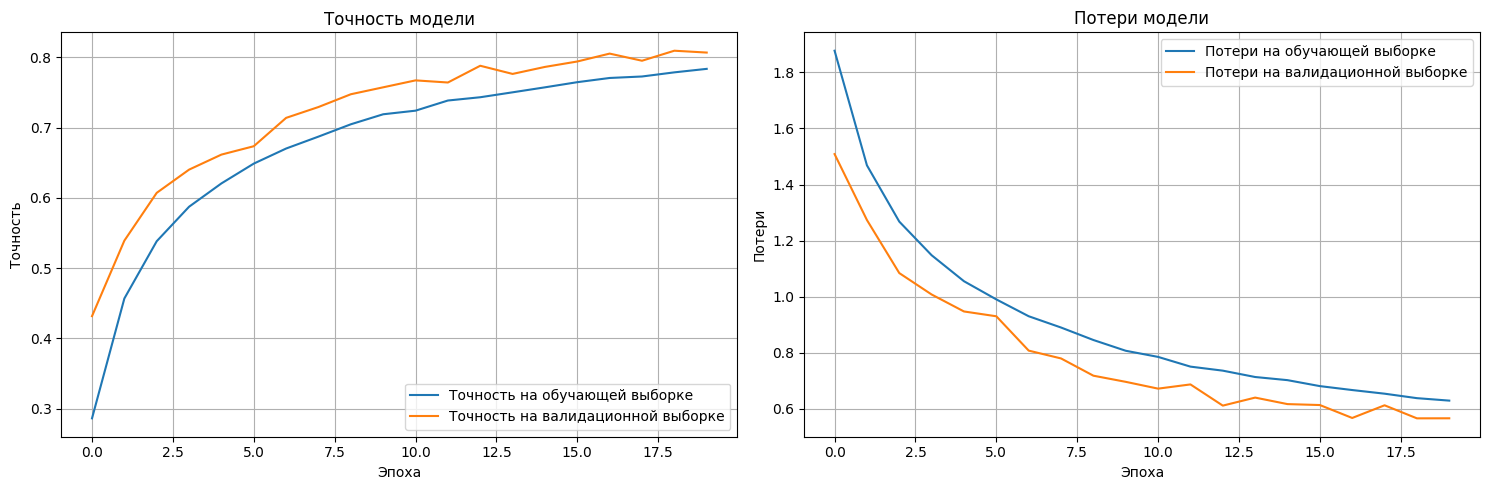

In [11]:
# Графики точности и потерь
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# График точности
axes[0].plot(history['accuracy'], label='Точность на обучающей выборке')
axes[0].plot(history['val_accuracy'], label='Точность на валидационной выборке')
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('Точность')
axes[0].set_title('Точность модели')
axes[0].legend()
axes[0].grid(True)

# График потерь
axes[1].plot(history['loss'], label='Потери на обучающей выборке')
axes[1].plot(history['val_loss'], label='Потери на валидационной выборке')
axes[1].set_xlabel('Эпоха')
axes[1].set_ylabel('Потери')
axes[1].set_title('Потери модели')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


## Предсказания на тестовых данных


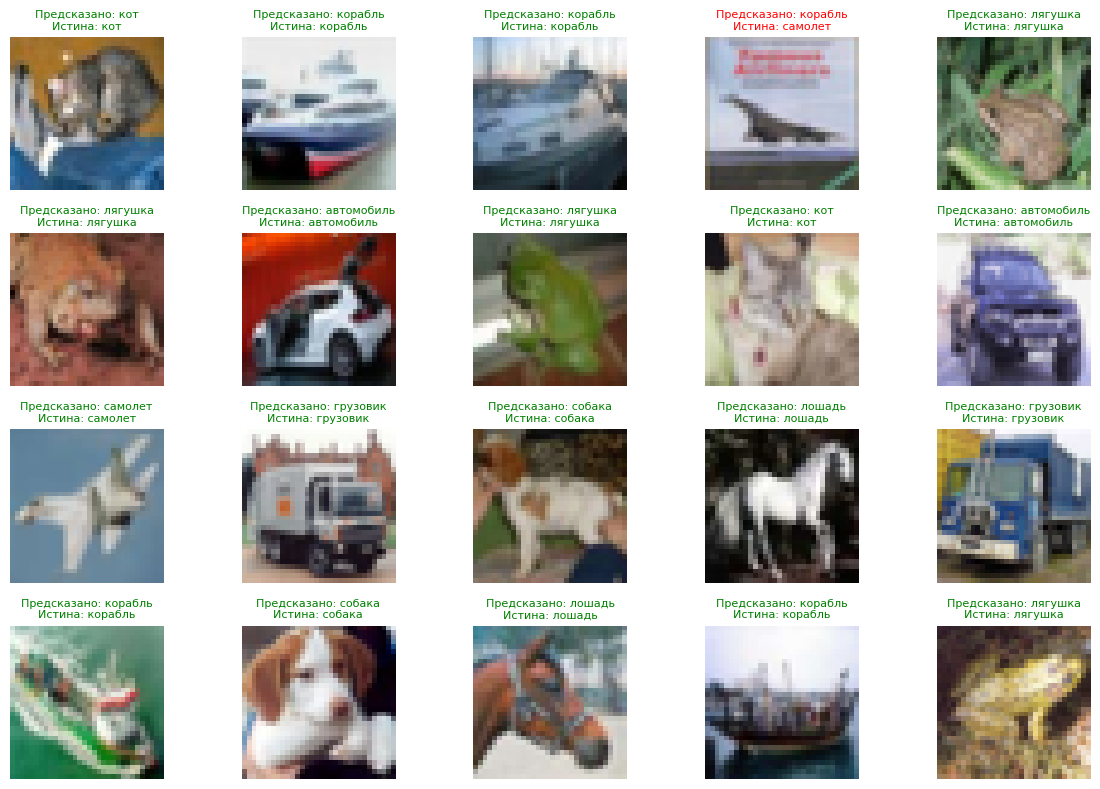

In [12]:
# Получаем предсказания на тестовых данных
@torch.no_grad()
def predict_all(model, loader, device):
    model.eval()
    preds = []
    trues = []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        preds.append(logits.argmax(dim=1).cpu().numpy())
        trues.append(yb.cpu().numpy())
    return np.concatenate(preds), np.concatenate(trues)

predicted_classes, true_classes = predict_all(model, test_loader, device)

# Визуализация нескольких предсказаний
plt.figure(figsize=(12, 8))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    img, _ = raw_test[i]
    plt.imshow(img.permute(1, 2, 0))

    predicted_label = class_names[int(predicted_classes[i])]
    true_label = class_names[int(true_classes[i])]

    color = 'green' if int(predicted_classes[i]) == int(true_classes[i]) else 'red'
    plt.title(f'Предсказано: {predicted_label}\nИстина: {true_label}', color=color, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Матрица ошибок (Confusion Matrix)


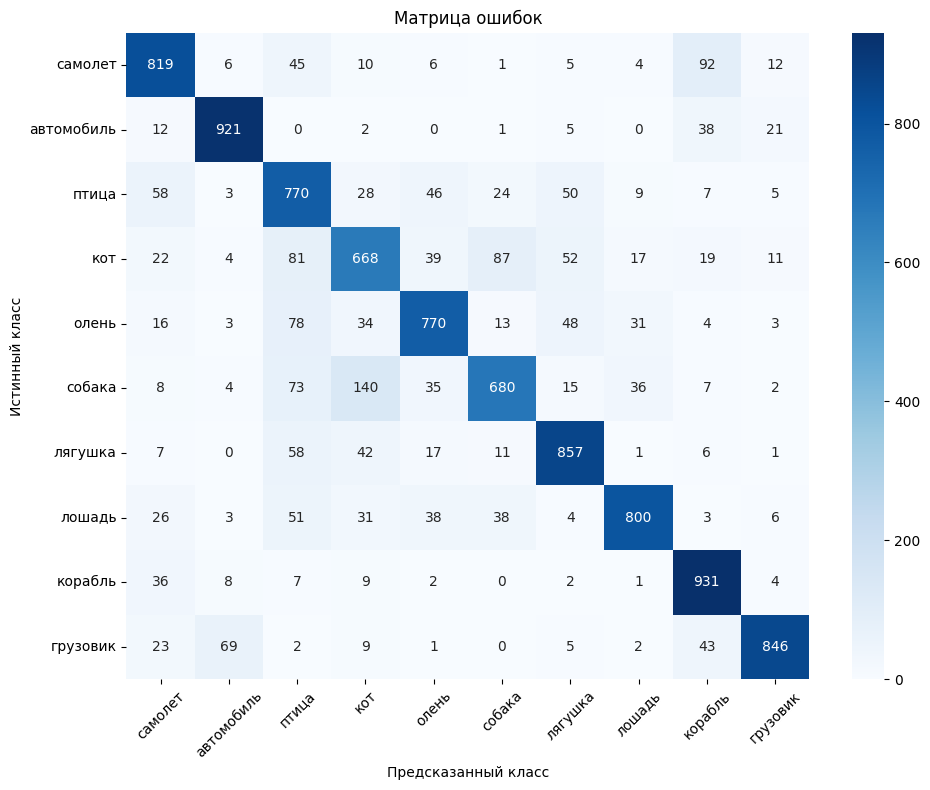


Отчёт о классификации:
              precision    recall  f1-score   support

     самолет       0.80      0.82      0.81      1000
  автомобиль       0.90      0.92      0.91      1000
       птица       0.66      0.77      0.71      1000
         кот       0.69      0.67      0.68      1000
       олень       0.81      0.77      0.79      1000
      собака       0.80      0.68      0.73      1000
     лягушка       0.82      0.86      0.84      1000
      лошадь       0.89      0.80      0.84      1000
     корабль       0.81      0.93      0.87      1000
    грузовик       0.93      0.85      0.89      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Вычисление матрицы ошибок
cm = confusion_matrix(true_classes, predicted_classes)

# Визуализация матрицы ошибок
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Матрица ошибок')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Отчёт о классификации
print("\nОтчёт о классификации:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))
